# 🤖 BTC News — FinBERT + CNN-BiLSTM v3
**FinBERT (offline, CPU) → feature extraction → CNN-BiLSTM classifier**

### Stratégie :
1. FinBERT **figé** (frozen) → extraction embeddings 768d une seule fois
2. CNN + Attention par-dessus les embeddings
3. Branch numérique (sentiment, rolling features, TF-IDF SVD)
4. Fusion → classification UP/DOWN

### Prérequis :
- Dossier `../models/finbert/` contenant les fichiers FinBERT téléchargés
- Si pas encore fait, sur une machine avec internet :
```bash
pip install transformers torch
python -c "
from transformers import BertTokenizer, BertModel
BertTokenizer.from_pretrained('ProsusAI/finbert').save_pretrained('../models/finbert')
BertModel.from_pretrained('ProsusAI/finbert').save_pretrained('../models/finbert')
"
```

## Cell 0 — Installation & Téléchargement FinBERT *(exécuter une seule fois)*

In [2]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  ÉTAPE 0 — Installation + téléchargement FinBERT            ║
# ║  Exécute cette cellule UNE SEULE FOIS dans ton venv          ║
# ║  Nécessite internet — après, tu peux travailler offline      ║
# ╚══════════════════════════════════════════════════════════════╝

import sys, os

# ── 1. Installation des packages dans le venv actif ─────────────
print("📦 Installation de transformers et torch...")
!{sys.executable} -m pip install transformers torch --quiet
print("✅ Packages installés")

# ── 2. Téléchargement FinBERT depuis HuggingFace ────────────────
FINBERT_SAVE_DIR = "../models/finbert"
os.makedirs(FINBERT_SAVE_DIR, exist_ok=True)

from transformers import BertTokenizer, BertModel

print(f"⬇️  Téléchargement FinBERT → {FINBERT_SAVE_DIR}")
print("   (taille ~440 MB, patience...)")

tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
tokenizer.save_pretrained(FINBERT_SAVE_DIR)
print("✅ Tokenizer sauvegardé")

model_dl = BertModel.from_pretrained("ProsusAI/finbert")
model_dl.save_pretrained(FINBERT_SAVE_DIR)
print("✅ Modèle sauvegardé")

# ── 3. Vérification ─────────────────────────────────────────────
required = ["config.json", "tokenizer_config.json", "tokenizer.json"]
all_ok = all(os.path.exists(f"{FINBERT_SAVE_DIR}/{f}") for f in required)

if all_ok:
    files = os.listdir(FINBERT_SAVE_DIR)
    total_mb = sum(os.path.getsize(f"{FINBERT_SAVE_DIR}/{f}") for f in files) / 1e6
    print(f"🎉 FinBERT prêt dans {FINBERT_SAVE_DIR}/")
    print(f"   {len(files)} fichiers — {total_mb:.1f} MB")
    print("   Tu peux maintenant continuer avec les cellules suivantes ✅")
else:
    print("❌ Problème: certains fichiers manquent, réessaie.")


📦 Installation de transformers et torch...
✅ Packages installés


c:\Users\15086\Desktop\ml-dl-dashbord\dl-ml-btc\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⬇️  Téléchargement FinBERT → ../models/finbert
   (taille ~440 MB, patience...)
✅ Tokenizer sauvegardé


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 199.31it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.weight            | UNEXPECTED |  | 
classifier.bias              | UNEXPECTED |  | 
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Writing model shards: 100%|██████████| 1/1 [00:08<00:00,  8.69s/it]

✅ Modèle sauvegardé
🎉 FinBERT prêt dans ../models/finbert/
   4 fichiers — 438.7 MB
   Tu peux maintenant continuer avec les cellules suivantes ✅


## Cell 0 — ⬇️ Téléchargement FinBERT (à exécuter UNE SEULE FOIS sur machine avec internet)

In [4]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║  ÉTAPE PRÉLIMINAIRE — Exécuter UNE SEULE FOIS                   ║
# ║  Nécessite une connexion internet                                ║
# ║  Ensuite, copier ../models/finbert/ sur la machine offline       ║
# ╚══════════════════════════════════════════════════════════════════╝

import os, subprocess, sys

FINBERT_DIR = '../models/finbert'

# Vérifier si déjà téléchargé
already_done = all(
    os.path.exists(f'{FINBERT_DIR}/{f}')
    for f in ['config.json', 'tokenizer_config.json', 'tokenizer.json']
)

if already_done:
    print(f'✅ FinBERT déjà présent dans {FINBERT_DIR}/ — rien à faire.')
else:
    print('📦 Installation de transformers et torch...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install',
                           'transformers', 'torch', '--quiet'])

    print('⬇️  Téléchargement de FinBERT depuis HuggingFace (ProsusAI/finbert)...')
    print('   Taille ~430 MB — patience...')

    from transformers import BertTokenizer, BertModel

    os.makedirs(FINBERT_DIR, exist_ok=True)

    print('  [1/2] Tokenizer...')
    BertTokenizer.from_pretrained('ProsusAI/finbert').save_pretrained(FINBERT_DIR)
    print('  ✅ Tokenizer sauvegardé')

    print('  [2/2] Modèle (poids ~430 MB)...')
    BertModel.from_pretrained('ProsusAI/finbert').save_pretrained(FINBERT_DIR)
    print('  ✅ Modèle sauvegardé')

    print(f'🎉 FinBERT téléchargé et sauvegardé dans : {FINBERT_DIR}/')
    print('Fichiers présents :')
    for fname in sorted(os.listdir(FINBERT_DIR)):
        size = os.path.getsize(f'{FINBERT_DIR}/{fname}')
        unit = 'MB' if size > 1_000_000 else 'KB'
        val  = size / 1_000_000 if size > 1_000_000 else size / 1_000
        print(f'  ✅  {fname:<45} ({val:.1f} {unit})')

    print('⚠️  Maintenant copie le dossier ../models/finbert/ sur ta machine offline.')
    print('   Ensuite tu peux continuer avec les cellules suivantes.')


✅ FinBERT déjà présent dans ../models/finbert/ — rien à faire.


## Cell 1 — Imports & Setup

In [5]:
import os, re, random, warnings, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, balanced_accuracy_score, average_precision_score
)
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE

import torch
from transformers import BertTokenizer, BertModel

import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D,
    Bidirectional, LSTM, Dense, Dropout, Concatenate,
    BatchNormalization, MultiHeadAttention, LayerNormalization,
    Reshape
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

warnings.filterwarnings('ignore')

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# ── Chemins ──────────────────────────────────────────────────────────
OUT_DIR      = '../models/hybrid_cnn_bilstm'
FINBERT_DIR  = '../models/finbert'
NOTEBOOK_DIR = '../notebooks'

os.makedirs(OUT_DIR,      exist_ok=True)
os.makedirs(NOTEBOOK_DIR, exist_ok=True)

# CPU uniquement
DEVICE = torch.device('cpu')

print(f'TensorFlow : {tf.__version__}')
print(f'PyTorch    : {torch.__version__}')
print(f'Device     : {DEVICE}')
print(f'FinBERT dir: {FINBERT_DIR}')

# Vérifier que FinBERT est présent
required_files = ['config.json', 'tokenizer_config.json', 'tokenizer.json']
missing = [f for f in required_files if not os.path.exists(f'{FINBERT_DIR}/{f}')]
if missing:
    print(f'\n❌ ERREUR: Fichiers FinBERT manquants dans {FINBERT_DIR}/:')
    for m in missing:
        print(f'   - {m}')
    print('\nTélécharge FinBERT avec les commandes dans la cellule markdown ci-dessus.')
else:
    print(f'\n✅ FinBERT trouvé dans {FINBERT_DIR}/')

TensorFlow : 2.20.0
PyTorch    : 2.10.0+cpu
Device     : cpu
FinBERT dir: ../models/finbert

✅ FinBERT trouvé dans ../models/finbert/


## Cell 2 — Chargement FinBERT (offline)

In [6]:
print('Chargement FinBERT depuis le dossier local...')

finbert_tokenizer = BertTokenizer.from_pretrained(FINBERT_DIR, local_files_only=True)
finbert_model     = BertModel.from_pretrained(FINBERT_DIR, local_files_only=True)
finbert_model.eval()  # mode inférence
finbert_model.to(DEVICE)

# Geler tous les paramètres — on ne fine-tune PAS FinBERT
for param in finbert_model.parameters():
    param.requires_grad = False

FINBERT_DIM = 768  # dimension de sortie de FinBERT
print(f'✅ FinBERT chargé et figé (frozen)')
print(f'   Paramètres FinBERT : {sum(p.numel() for p in finbert_model.parameters()):,} (tous figés)')
print(f'   Dimension output   : {FINBERT_DIM}')

Chargement FinBERT depuis le dossier local...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 471.79it/s, Materializing param=pooler.dense.weight]                               


✅ FinBERT chargé et figé (frozen)
   Paramètres FinBERT : 109,482,240 (tous figés)
   Dimension output   : 768


## Cell 3 — Loss + Callbacks

In [7]:
class DiversityFocalLoss(keras.losses.Loss):
    """Focal Loss + pénalité diversité pour éviter prédiction collapse."""
    def __init__(self, gamma=2.0, alpha=0.65, label_smoothing=0.08,
                 diversity_weight=0.4, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.label_smoothing = label_smoothing
        self.diversity_weight = diversity_weight

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_smooth = y_true * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        bce = -y_smooth * tf.math.log(y_pred) - (1.0 - y_smooth) * tf.math.log(1.0 - y_pred)
        p_t = tf.where(tf.cast(y_true, tf.bool), y_pred, 1.0 - y_pred)
        alpha_t = tf.where(
            tf.cast(y_true, tf.bool),
            tf.ones_like(y_true) * self.alpha,
            tf.ones_like(y_true) * (1.0 - self.alpha),
        )
        focal_loss = tf.reduce_mean(alpha_t * tf.pow(1.0 - p_t, self.gamma) * bce)
        diversity_penalty = tf.square(tf.reduce_mean(y_pred) - 0.5) * self.diversity_weight
        return focal_loss + diversity_penalty

    def get_config(self):
        cfg = super().get_config()
        cfg.update({'gamma': self.gamma, 'alpha': self.alpha,
                    'label_smoothing': self.label_smoothing,
                    'diversity_weight': self.diversity_weight})
        return cfg


class DiversityMonitorCallback(Callback):
    """Affiche le ratio UP/DOWN à chaque epoch."""
    def __init__(self, validation_data, threshold=0.10):
        super().__init__()
        self.X_val = validation_data[0]
        self.y_val = validation_data[1]
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        prob = self.model.predict(self.X_val, verbose=0).flatten()
        up   = (prob >= 0.5).mean()
        if up < self.threshold or (1 - up) < self.threshold:
            print(f'\n⚠️  COLLAPSE UP={up:.1%} DOWN={1-up:.1%}')
        else:
            print(f'  | UP={up:.1%} DOWN={1-up:.1%}', end='')

print('✅ DiversityFocalLoss + DiversityMonitorCallback définis')

✅ DiversityFocalLoss + DiversityMonitorCallback définis


## Cell 4 — Chargement données

In [8]:
CSV_PATH = '../data/raw/btc_news.csv'
df = pd.read_csv(CSV_PATH)

# Supprimer colonnes de leakage
LEAKAGE_COLS = ['price_next_day', 'price_change_next_day']
df = df.drop(columns=[c for c in LEAKAGE_COLS if c in df.columns])

# Nettoyage
df = df.dropna(subset=['text_clean', 'label', 'date'])
df = df[df['text_clean'].str.strip() != '']
df['sentiment_score']  = pd.to_numeric(df['sentiment_score'],  errors='coerce').fillna(0.0)
df['price_change_24h'] = pd.to_numeric(df['price_change_24h'], errors='coerce').fillna(0.0)
df['price']    = pd.to_numeric(df['price'], errors='coerce').fillna(df['price'].median() if 'price' in df else 0)
df['severity'] = pd.to_numeric(df['severity'], errors='coerce').fillna(1).clip(1, 10).astype(int)
df['category'] = df['category'].fillna('OTHER')
df['label']    = df['label'].astype(int)
df['date']     = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df = df.sort_values('date').reset_index(drop=True)

# Limiter la longueur du texte pour FinBERT (max 512 tokens → ~400 mots)
df['text_clean'] = df['text_clean'].str.slice(0, 1500)

print(f'Dataset      : {len(df):,} articles')
print(f'Jours uniques: {df["date"].nunique()}')
print(f'UP ratio     : {df["label"].mean():.2%}')
print(f'DOWN ratio   : {1 - df["label"].mean():.2%}')

Dataset      : 2,575 articles
Jours uniques: 50
UP ratio     : 39.65%
DOWN ratio   : 60.35%


## Cell 5 — Feature Engineering (agrégats + rolling)

In [9]:
CATEGORIES = ['REGULATORY', 'SECURITY', 'MACRO', 'TECH', 'ADOPTION', 'MARKET', 'OTHER']

# Source
if 'source' in df.columns:
    df['source_clean'] = df['source'].str.extract(r'([^/]+)$').fillna('Unknown')
    top_sources = df['source_clean'].value_counts().head(6).index.tolist()
    df['source_clean'] = df['source_clean'].apply(lambda x: x if x in top_sources else 'Other')
    SOURCES = sorted(df['source_clean'].unique().tolist())
else:
    df['source_clean'] = 'Unknown'
    SOURCES = ['Unknown']

df['is_negative'] = (df['sentiment_score'] < -0.1).astype(float)
df['is_positive'] = (df['sentiment_score'] >  0.1).astype(float)

# ── Agrégats journaliers ─────────────────────────────────────────────
id_col = 'event_id' if 'event_id' in df.columns else 'label'
daily = df.groupby('date').agg(
    volume_news=(id_col, 'count'),
    avg_sentiment=('sentiment_score', 'mean'),
    std_sentiment=('sentiment_score', 'std'),
    avg_price_change=('price_change_24h', 'mean'),
    max_severity=('severity', 'max'),
    avg_severity=('severity', 'mean'),
    neg_news_ratio=('is_negative', 'mean'),
    pos_news_ratio=('is_positive', 'mean'),
    sentiment_range=('sentiment_score', lambda x: x.max() - x.min()),
    max_sentiment=('sentiment_score', 'max'),
    min_sentiment=('sentiment_score', 'min'),
    price=('price', 'first'),
).reset_index()

daily['std_sentiment'] = daily['std_sentiment'].fillna(0)
daily['log_price']     = np.log(daily['price'].replace(0, np.nan)).fillna(0)
daily = daily.sort_values('date').reset_index(drop=True)

# ── Rolling features ─────────────────────────────────────────────────
daily['sent_momentum_3d']   = daily['avg_sentiment'].rolling(3, min_periods=1).mean()
daily['sent_momentum_5d']   = daily['avg_sentiment'].rolling(5, min_periods=1).mean()
daily['vol_momentum_3d']    = daily['volume_news'].rolling(3, min_periods=1).mean()
daily['sent_volatility_5d'] = daily['avg_sentiment'].rolling(5, min_periods=1).std().fillna(0)
daily['price_log_return']   = np.log(daily['price'] / daily['price'].shift(1)).fillna(0)
daily['price_lr_3d']        = daily['price_log_return'].rolling(3, min_periods=1).mean()
daily['news_momentum']      = daily['volume_news'].rolling(3, min_periods=1).mean()
daily['volume_accel']       = daily['volume_news'].diff().fillna(0)
daily['sent_trend_5d']      = daily['avg_sentiment'].rolling(5, min_periods=1).apply(
    lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0
)

# Temporel cyclique
daily['date_dt']   = pd.to_datetime(daily['date'])
daily['dow']       = daily['date_dt'].dt.dayofweek
daily['dow_sin']   = np.sin(2 * np.pi * daily['dow'] / 7)
daily['dow_cos']   = np.cos(2 * np.pi * daily['dow'] / 7)
daily['is_weekend']= (daily['dow'] >= 5).astype(float)
daily['is_monday'] = (daily['dow'] == 0).astype(float)
daily['is_friday'] = (daily['dow'] == 4).astype(float)

# Merge
df = df.merge(
    daily.drop(columns=['price', 'date_dt', 'dow'], errors='ignore'),
    on='date', how='left'
)
df = df.fillna(0)

print(f'✅ Feature engineering terminé. Shape: {df.shape}')

✅ Feature engineering terminé. Shape: (2575, 42)


## Cell 6 — Split temporel (70/15/15)

In [10]:
unique_dates = sorted(df['date'].unique())
n_dates = len(unique_dates)

train_dates = unique_dates[:int(n_dates * 0.70)]
val_dates   = unique_dates[int(n_dates * 0.70):int(n_dates * 0.85)]
test_dates  = unique_dates[int(n_dates * 0.85):]

idx_train = df[df['date'].isin(train_dates)].index.tolist()
idx_val   = df[df['date'].isin(val_dates)].index.tolist()
idx_test  = df[df['date'].isin(test_dates)].index.tolist()

texts  = df['text_clean'].values
labels = df['label'].values

y_train = labels[idx_train]
y_val   = labels[idx_val]
y_test  = labels[idx_test]

print(f'Train : {len(idx_train):,} articles ({len(train_dates)} jours) | UP={y_train.mean():.2%}')
print(f'Val   : {len(idx_val):,} articles ({len(val_dates)} jours) | UP={y_val.mean():.2%}')
print(f'Test  : {len(idx_test):,} articles ({len(test_dates)} jours) | UP={y_test.mean():.2%}')

Train : 675 articles (35 jours) | UP=32.59%
Val   : 699 articles (7 jours) | UP=20.46%
Test  : 1,201 articles (8 jours) | UP=54.79%


## Cell 7 — Extraction embeddings FinBERT ⚡
**Cette cellule peut prendre 10-30 min sur CPU selon la taille du dataset.**  
Les embeddings sont sauvegardés sur disque pour éviter de recalculer.

In [11]:
EMBED_CACHE = f'{OUT_DIR}/finbert_embeddings.npy'
FINBERT_MAX_LEN = 128   # 128 tokens = bon compromis vitesse/qualité sur CPU
BATCH_SIZE_BERT = 16    # petit batch pour CPU

def extract_finbert_embeddings(text_list, batch_size=BATCH_SIZE_BERT):
    """
    Extrait le [CLS] embedding de FinBERT pour chaque texte.
    Retourne un array numpy (N, 768).
    """
    all_embeddings = []
    n_batches = (len(text_list) + batch_size - 1) // batch_size

    with torch.no_grad():
        for i in tqdm(range(0, len(text_list), batch_size),
                      total=n_batches, desc='FinBERT extraction'):
            batch_texts = text_list[i:i + batch_size]
            # Tokenisation
            encoded = finbert_tokenizer(
                list(batch_texts),
                max_length=FINBERT_MAX_LEN,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            encoded = {k: v.to(DEVICE) for k, v in encoded.items()}
            # Forward pass
            outputs = finbert_model(**encoded)
            # [CLS] token = premier token = représentation globale de la phrase
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_embeddings)

    return np.vstack(all_embeddings).astype(np.float32)


# Utiliser le cache si disponible
if os.path.exists(EMBED_CACHE):
    print(f'✅ Cache trouvé : {EMBED_CACHE}')
    print('   Chargement des embeddings depuis le cache...')
    all_embeddings = np.load(EMBED_CACHE)
    print(f'   Shape: {all_embeddings.shape}')
else:
    print(f'⏳ Extraction FinBERT pour {len(df):,} articles...')
    print(f'   MAX_LEN={FINBERT_MAX_LEN}, BATCH={BATCH_SIZE_BERT}')
    print(f'   Temps estimé CPU: ~{len(df) // 60} min\n')
    all_embeddings = extract_finbert_embeddings(texts)
    np.save(EMBED_CACHE, all_embeddings)
    print(f'\n✅ Embeddings sauvegardés dans {EMBED_CACHE}')
    print(f'   Shape: {all_embeddings.shape}')

# Split
X_bert_train = all_embeddings[idx_train]
X_bert_val   = all_embeddings[idx_val]
X_bert_test  = all_embeddings[idx_test]

# Normaliser les embeddings FinBERT
bert_scaler = StandardScaler()
X_bert_train = bert_scaler.fit_transform(X_bert_train)
X_bert_val   = bert_scaler.transform(X_bert_val)
X_bert_test  = bert_scaler.transform(X_bert_test)

print(f'\nX_bert_train: {X_bert_train.shape}')
print(f'X_bert_val  : {X_bert_val.shape}')
print(f'X_bert_test : {X_bert_test.shape}')

⏳ Extraction FinBERT pour 2,575 articles...
   MAX_LEN=128, BATCH=16
   Temps estimé CPU: ~42 min



FinBERT extraction: 100%|██████████| 161/161 [08:06<00:00,  3.02s/it]


✅ Embeddings sauvegardés dans ../models/hybrid_cnn_bilstm/finbert_embeddings.npy
   Shape: (2575, 768)

X_bert_train: (675, 768)
X_bert_val  : (699, 768)
X_bert_test : (1201, 768)


## Cell 8 — Features numériques + TF-IDF SVD

In [12]:
CONTINUOUS_COLS = [
    'sentiment_score', 'price_change_24h', 'severity',
    'volume_news', 'avg_sentiment', 'std_sentiment',
    'avg_price_change', 'max_severity', 'avg_severity',
    'log_price', 'neg_news_ratio', 'pos_news_ratio',
    'sent_momentum_3d', 'sent_momentum_5d', 'vol_momentum_3d',
    'sent_volatility_5d', 'price_log_return', 'price_lr_3d',
    'dow_sin', 'dow_cos', 'is_weekend', 'is_monday', 'is_friday',
    'sentiment_range', 'max_sentiment', 'min_sentiment',
    'news_momentum', 'sent_trend_5d', 'volume_accel',
]
CONTINUOUS_COLS = [c for c in CONTINUOUS_COLS if c in df.columns]

# One-hot
le_cat = LabelEncoder().fit(CATEGORIES)
cat_enc = le_cat.transform(df['category'].apply(lambda x: x if x in CATEGORIES else 'OTHER'))
cat_ohe = tf.keras.utils.to_categorical(cat_enc, num_classes=len(CATEGORIES))

le_src = LabelEncoder().fit(SOURCES)
src_enc = le_src.transform(df['source_clean'])
src_ohe = tf.keras.utils.to_categorical(src_enc, num_classes=len(SOURCES))

continuous_raw = df[CONTINUOUS_COLS].fillna(0).values.astype(np.float32)
scaler = StandardScaler()
cont_train = scaler.fit_transform(continuous_raw[idx_train])
cont_val   = scaler.transform(continuous_raw[idx_val])
cont_test  = scaler.transform(continuous_raw[idx_test])

# TF-IDF SVD
N_SVD = 50
tfidf = TfidfVectorizer(max_features=15_000, ngram_range=(1, 2), sublinear_tf=True, min_df=2)
tfidf.fit(texts[idx_train])

svd = TruncatedSVD(n_components=N_SVD, random_state=SEED)
svd.fit(tfidf.transform(texts[idx_train]))

def svd_feat(idx):
    return svd.transform(tfidf.transform(texts[idx])).astype(np.float32)

svd_train = svd_feat(idx_train)
svd_val   = svd_feat(idx_val)
svd_test  = svd_feat(idx_test)

svd_scaler = StandardScaler()
svd_train = svd_scaler.fit_transform(svd_train)
svd_val   = svd_scaler.transform(svd_val)
svd_test  = svd_scaler.transform(svd_test)

# Assemblage numérique
X_num_train = np.hstack([cont_train, cat_ohe[idx_train], src_ohe[idx_train], svd_train]).astype(np.float32)
X_num_val   = np.hstack([cont_val,   cat_ohe[idx_val],   src_ohe[idx_val],   svd_val]).astype(np.float32)
X_num_test  = np.hstack([cont_test,  cat_ohe[idx_test],  src_ohe[idx_test],  svd_test]).astype(np.float32)

NUM_DIM = X_num_train.shape[1]
print(f'NUM_DIM       : {NUM_DIM}')
print(f'FINBERT_DIM   : {FINBERT_DIM}')
print(f'X_num_train   : {X_num_train.shape}')

NUM_DIM       : 93
FINBERT_DIM   : 768
X_num_train   : (675, 93)


## Cell 9 — SMOTE sur features combinées

In [13]:
# SMOTE sur: FinBERT embeddings + features continues
# (meilleure interpolation car espaces sémantiquement cohérents)
X_smote_input = np.hstack([X_bert_train, cont_train])

smote = SMOTE(sampling_strategy=0.85, random_state=SEED, k_neighbors=5)
X_smote_out, y_smote = smote.fit_resample(X_smote_input, y_train)

n_original  = len(y_train)
n_synthetic = len(y_smote) - n_original

# Trouver voisins pour les échantillons synthétiques
nn = NearestNeighbors(n_neighbors=1).fit(X_smote_input)
_, indices = nn.kneighbors(X_smote_out[n_original:])
synth_idx = indices.flatten()

# Reconstruire les features complètes pour les synthétiques
bert_dim = X_bert_train.shape[1]
cont_dim = cont_train.shape[1]

# FinBERT embeddings: interpolés par SMOTE
X_bert_synth = X_smote_out[n_original:, :bert_dim]
X_bert_smote = np.vstack([X_bert_train, X_bert_synth]).astype(np.float32)

# Features numériques: combinaison interpolée + OHE du voisin
cat_src_train = np.hstack([cat_ohe[idx_train], src_ohe[idx_train]])
cat_src_synth = cat_src_train[synth_idx]
cont_synth    = X_smote_out[n_original:, bert_dim:]
svd_synth     = svd_train[synth_idx]

X_num_smote = np.hstack([
    np.vstack([cont_train, cont_synth]),
    np.vstack([cat_src_train, cat_src_synth]),
    np.vstack([svd_train, svd_synth]),
]).astype(np.float32)

print(f'Après SMOTE:')
print(f'  Total   : {len(y_smote):,}  (réels: {n_original:,}, synthétiques: {n_synthetic:,})')
print(f'  UP ratio: {y_smote.mean():.2%}')
print(f'  X_bert_smote shape: {X_bert_smote.shape}')
print(f'  X_num_smote  shape: {X_num_smote.shape}')

Après SMOTE:
  Total   : 841  (réels: 675, synthétiques: 166)
  UP ratio: 45.90%
  X_bert_smote shape: (841, 768)
  X_num_smote  shape: (841, 93)


## Cell 10 — Architecture FinBERT-CNN-BiLSTM

In [14]:
def build_finbert_model(dropout_rate=0.40, lstm_units=64, dense_units=128,
                        l1_reg=0.0005, l2_reg=0.001):
    """
    Architecture:
    - Branche BERT  : embeddings 768d → Reshape → CNN(k=3) + 4-head Attention + BiLSTM
    - Branche NUM   : features numériques + TF-IDF SVD → Dense
    - Fusion        : Concat → Dense → Sigmoid
    """

    # ── Branche FinBERT ──────────────────────────────────────────────
    # Input: embeddings FinBERT (768 dims, déjà normalisés)
    bert_input = Input(shape=(FINBERT_DIM,), name='bert_input')

    # Reshape (768,) → (16, 48) pour appliquer CNN
    # 16 "tokens" de 48 dimensions chacun
    bert_reshaped = Reshape((16, 48))(bert_input)

    # CNN sur l'espace FinBERT reshapé
    conv = Conv1D(64, 3, activation='relu', padding='same',
                  kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(bert_reshaped)
    conv = BatchNormalization()(conv)

    # Attention sur CNN
    attn = MultiHeadAttention(num_heads=4, key_dim=16, dropout=0.1)(conv, conv)
    attn = LayerNormalization()(attn + conv)  # résiduel

    pool_avg = GlobalAveragePooling1D()(attn)
    pool_max = GlobalMaxPooling1D()(attn)
    bert_cnn_out = Concatenate()([pool_avg, pool_max])  # (128,)

    # BiLSTM sur l'espace FinBERT reshapé
    lstm_out = Bidirectional(
        LSTM(lstm_units, return_sequences=False, dropout=0.2),
        name='bilstm'
    )(bert_reshaped)

    # Projection directe de l'embedding CLS
    bert_proj = Dense(128, activation='relu',
                      kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                      name='bert_proj')(bert_input)
    bert_proj = BatchNormalization()(bert_proj)
    bert_proj = Dropout(dropout_rate)(bert_proj)

    # Fusionner les 3 représentations BERT
    bert_out = Concatenate()([bert_cnn_out, lstm_out, bert_proj])
    bert_out = BatchNormalization()(bert_out)
    bert_out = Dropout(dropout_rate)(bert_out)

    # ── Branche numérique ────────────────────────────────────────────
    num_input = Input(shape=(NUM_DIM,), name='num_input')
    num_x = Dense(128, activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(num_input)
    num_x = BatchNormalization()(num_x)
    num_x = Dropout(dropout_rate)(num_x)
    num_x = Dense(64, activation='relu',
                  kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(num_x)
    num_x = BatchNormalization()(num_x)
    num_x = Dropout(dropout_rate * 0.75)(num_x)

    # ── Fusion finale ────────────────────────────────────────────────
    merged = Concatenate()([bert_out, num_x])
    x = Dense(dense_units, activation='relu',
              kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(merged)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate * 0.5)(x)

    output = Dense(1, activation='sigmoid', name='output')(x)

    return Model(inputs=[bert_input, num_input], outputs=output)


model = build_finbert_model()
model.summary()
print(f'\nParamètres entraînables : {model.count_params():,}')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ bert_input          │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 16, 48)    │          0 │ bert_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 16, 64)    │      9,280 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 64)    │     16,640 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 93)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 16, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_proj (Dense)   │ (None, 128)       │     98,432 │ bert_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,032 │ num_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bert_proj[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 128)       │     57,856 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ concatenate[0][0

 Total params: 272,001 (1.04 MB)

 Trainable params: 270,209 (1.03 MB)

 Non-trainable params: 1,792 (7.00 KB)


Paramètres entraînables : 272,001


## Cell 11 — Compilation & Entraînement

In [15]:
# Poids de classes
class_weight_0 = len(y_smote) / (2 * (1 - y_smote).sum())
class_weight_1 = len(y_smote) / (2 * y_smote.sum())
class_weights  = {0: class_weight_0, 1: class_weight_1}
print(f'Class weights: DOWN={class_weight_0:.3f}, UP={class_weight_1:.3f}')

model.compile(
    optimizer=Adam(learning_rate=3e-4, clipnorm=1.0),
    loss=DiversityFocalLoss(gamma=2.0, alpha=0.65, label_smoothing=0.08, diversity_weight=0.4),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ],
)
print('✅ Modèle compilé')

TOTAL_EPOCHS = 100

callbacks = [
    EarlyStopping(
        monitor='val_auc', patience=15, mode='max',
        restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_auc', factor=0.5, patience=7,
        mode='max', min_lr=1e-6, verbose=1
    ),
    DiversityMonitorCallback(
        validation_data=([X_bert_val, X_num_val], y_val),
        threshold=0.15
    ),
]

print(f'\nEntraînement sur {len(y_smote):,} samples, {TOTAL_EPOCHS} epochs max...')
history = model.fit(
    [X_bert_smote, X_num_smote],
    y_smote,
    validation_data=([X_bert_val, X_num_val], y_val),
    epochs=TOTAL_EPOCHS,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Class weights: DOWN=0.924, UP=1.089
✅ Modèle compilé

Entraînement sur 841 samples, 100 epochs max...
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.4756 - auc: 0.4883 - loss: 5.4889 - pr_auc: 0.4595 - precision: 0.4440 - recall: 0.5648 - val_accuracy: 0.6581 - val_auc: 0.4521 - val_loss: 5.2636 - val_pr_auc: 0.1814 - val_precision: 0.1620 - val_recall: 0.1608 - learning_rate: 3.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4911 - auc: 0.5077 - loss: 5.3727 - pr_auc: 0.4611 - precision: 0.4587 - recall: 0.6036 - val_accuracy: 0.5737 - val_auc: 0.4601 - val_loss: 5.1602 - val_pr_auc: 0.1804 - val_precision: 0.1784 - val_recall: 0.3007 - learning_rate: 3.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4994 - auc: 0.4987 - loss: 5.2596 - pr_auc: 0.4387 - precision: 0.4639 - recall: 0.5829 - val_accuracy: 0.5479 - val_auc: 0.4696 - val_loss: 5.0565 - val_pr_auc: 0.1827 - val_precision: 0.1808 - val_recall: 0.3427 

## Cell 12 — Courbes d'apprentissage

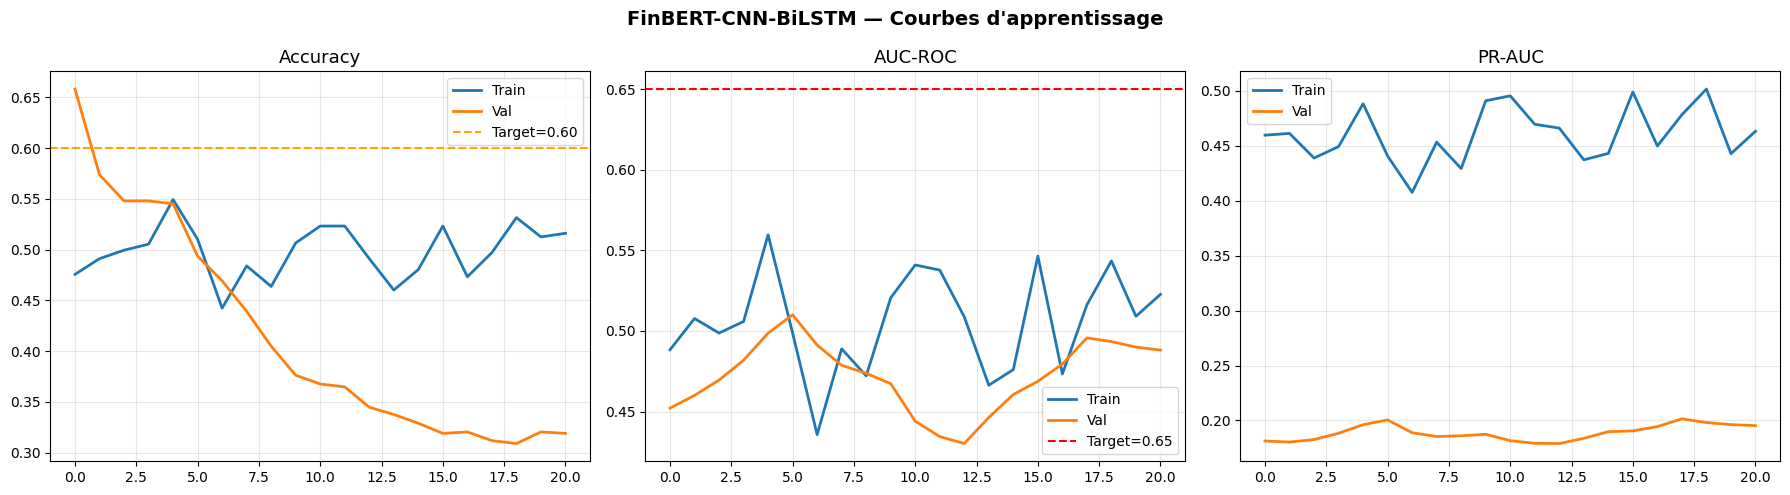

✅ Courbes sauvegardées


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('FinBERT-CNN-BiLSTM — Courbes d\'apprentissage', fontsize=14, fontweight='bold')

for ax, metric, title in zip(
    axes,
    ['accuracy', 'auc', 'pr_auc'],
    ['Accuracy', 'AUC-ROC', 'PR-AUC']
):
    ax.plot(history.history[metric],          label='Train', linewidth=2)
    ax.plot(history.history[f'val_{metric}'], label='Val',   linewidth=2)
    if metric == 'auc':
        ax.axhline(y=0.65, color='r', linestyle='--', label='Target=0.65')
    if metric == 'accuracy':
        ax.axhline(y=0.60, color='orange', linestyle='--', label='Target=0.60')
    ax.set_title(title, fontsize=13)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUT_DIR}/finbert_learning_curves.png', dpi=120, bbox_inches='tight')
plt.show()
print(f'✅ Courbes sauvegardées')

## Cell 13 — Recherche de seuil optimal

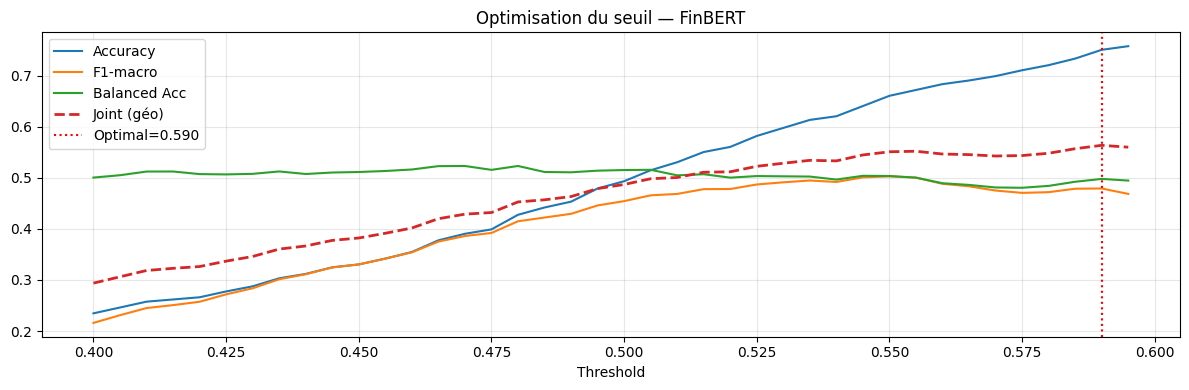

Seuil optimal    : 0.590
Val Accuracy     : 0.7511
Val F1-macro     : 0.4793
Val Balanced Acc : 0.4981


In [17]:
y_val_prob = model.predict([X_bert_val, X_num_val], verbose=0).flatten()

best_score  = -1
best_thresh = 0.5
results     = []

for t in np.arange(0.1, 0.9, 0.005):
    y_pred_t = (y_val_prob >= t).astype(int)
    up_ratio = y_pred_t.mean()
    if up_ratio < 0.05 or up_ratio > 0.95:
        continue
    acc_t = accuracy_score(y_val, y_pred_t)
    f1_t  = f1_score(y_val, y_pred_t, average='macro', zero_division=0)
    bal_t = balanced_accuracy_score(y_val, y_pred_t)
    # Moyenne géométrique des 3 métriques
    score = (acc_t * f1_t * bal_t) ** (1/3)
    results.append((t, acc_t, f1_t, bal_t, score))
    if score > best_score:
        best_score  = score
        best_thresh = t

res_df = pd.DataFrame(results, columns=['threshold', 'accuracy', 'f1_macro', 'bal_acc', 'joint'])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(res_df['threshold'], res_df['accuracy'],  label='Accuracy')
ax.plot(res_df['threshold'], res_df['f1_macro'],  label='F1-macro')
ax.plot(res_df['threshold'], res_df['bal_acc'],   label='Balanced Acc')
ax.plot(res_df['threshold'], res_df['joint'],     label='Joint (géo)', lw=2, ls='--')
ax.axvline(best_thresh, color='red', ls=':', label=f'Optimal={best_thresh:.3f}')
ax.set_xlabel('Threshold'); ax.legend(); ax.grid(True, alpha=0.3)
ax.set_title('Optimisation du seuil — FinBERT')
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/finbert_threshold.png', dpi=120)
plt.show()

THRESH = best_thresh
best_row = res_df.loc[res_df['joint'].idxmax()]
print(f'Seuil optimal    : {THRESH:.3f}')
print(f'Val Accuracy     : {best_row["accuracy"]:.4f}')
print(f'Val F1-macro     : {best_row["f1_macro"]:.4f}')
print(f'Val Balanced Acc : {best_row["bal_acc"]:.4f}')

## Cell 14 — Évaluation finale Test Set

  RÉSULTATS TEST SET — FinBERT-CNN-BiLSTM v3
  (Threshold=0.590)
  Accuracy         : 0.4621  ❌ < 0.60
  Balanced Accuracy: 0.5053
  AUC-ROC          : 0.5080
  F1-macro         : 0.3583
  Average Precision: 0.5517
  UP/DOWN          : 60 UP | 1141 DOWN (5.0% / 95.0%)

              precision    recall  f1-score   support

    DOWN (0)       0.45      0.96      0.62       543
      UP (1)       0.60      0.05      0.10       658

    accuracy                           0.46      1201
   macro avg       0.53      0.51      0.36      1201
weighted avg       0.53      0.46      0.33      1201

  COMPARAISON vs modèles précédents
  Modèle                      Accuracy   F1-macro        AUC
  -------------------------------------------------------
  CNN-BiLSTM (original)         0.3005     0.2389     0.5496
  IMPROVED                      0.4538     0.3173     0.4106
  OPTIMIZED                     0.4879     0.4538     0.5074
  V2 ENHANCED                   0.4438     0.3919     0.4681
  Fi

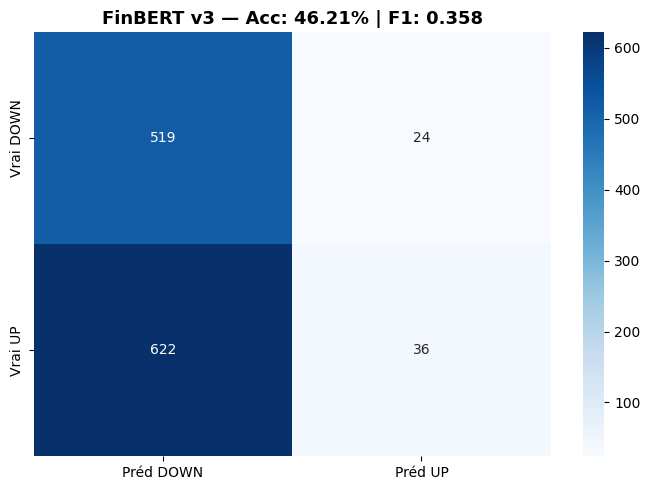

In [18]:
y_test_prob = model.predict([X_bert_test, X_num_test], verbose=0).flatten()
y_test_pred = (y_test_prob >= THRESH).astype(int)

test_acc          = accuracy_score(y_test, y_test_pred)
test_auc          = roc_auc_score(y_test, y_test_prob)
test_f1           = f1_score(y_test, y_test_pred, average='macro')
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_ap           = average_precision_score(y_test, y_test_prob)

n_up   = int(y_test_pred.sum())
n_down = int(len(y_test_pred) - n_up)

print('='*70)
print('  RÉSULTATS TEST SET — FinBERT-CNN-BiLSTM v3')
print(f'  (Threshold={THRESH:.3f})')
print('='*70)
print(f'  Accuracy         : {test_acc:.4f}  {"🎉 TARGET 0.65!" if test_acc >= 0.65 else ("✅ 0.60 MET!" if test_acc >= 0.60 else "❌ < 0.60")}')
print(f'  Balanced Accuracy: {test_balanced_acc:.4f}')
print(f'  AUC-ROC          : {test_auc:.4f}')
print(f'  F1-macro         : {test_f1:.4f}')
print(f'  Average Precision: {test_ap:.4f}')
print(f'  UP/DOWN          : {n_up} UP | {n_down} DOWN ({n_up/len(y_test):.1%} / {n_down/len(y_test):.1%})')
print()
print(classification_report(y_test, y_test_pred, target_names=['DOWN (0)', 'UP (1)'], zero_division=0))

# Comparaison
print('='*70)
print('  COMPARAISON vs modèles précédents')
print('='*70)
prev = {
    'CNN-BiLSTM (original)': (0.3005, 0.2389, 0.5496),
    'IMPROVED':              (0.4538, 0.3173, 0.4106),
    'OPTIMIZED':             (0.4879, 0.4538, 0.5074),
    'V2 ENHANCED':           (0.4438, 0.3919, 0.4681),
}
print(f'  {"Modèle":<25} {"Accuracy":>10} {"F1-macro":>10} {"AUC":>10}')
print('  ' + '-'*55)
for name, (acc, f1, auc) in prev.items():
    print(f'  {name:<25} {acc:>10.4f} {f1:>10.4f} {auc:>10.4f}')
print(f'  {"FinBERT v3 ★":<25} {test_acc:>10.4f} {test_f1:>10.4f} {test_auc:>10.4f}')

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Préd DOWN', 'Préd UP'],
            yticklabels=['Vrai DOWN', 'Vrai UP'])
plt.title(f'FinBERT v3 — Acc: {test_acc:.2%} | F1: {test_f1:.3f}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/finbert_confusion_matrix.png', dpi=120)
plt.show()

## Cell 15 — Sauvegarde complète + config.json

In [19]:
# ── Modèle ───────────────────────────────────────────────────────────
model.save(f'{OUT_DIR}/model.keras')
model.save(f'{OUT_DIR}/best_model.keras')
print('✅ model.keras + best_model.keras')

# ── Artefacts ────────────────────────────────────────────────────────
with open(f'{OUT_DIR}/scaler.pkl',             'wb') as f: pickle.dump(scaler,       f)
with open(f'{OUT_DIR}/bert_scaler.pkl',        'wb') as f: pickle.dump(bert_scaler,  f)
with open(f'{OUT_DIR}/tfidf.pkl',              'wb') as f: pickle.dump(tfidf,        f)
with open(f'{OUT_DIR}/svd.pkl',                'wb') as f: pickle.dump(svd,          f)
with open(f'{OUT_DIR}/svd_scaler.pkl',         'wb') as f: pickle.dump(svd_scaler,   f)
with open(f'{OUT_DIR}/label_encoder_cat.pkl',  'wb') as f: pickle.dump(le_cat,       f)
with open(f'{OUT_DIR}/label_encoder_src.pkl',  'wb') as f: pickle.dump(le_src,       f)
print('✅ Tous les artefacts sauvegardés')

# ── config.json ──────────────────────────────────────────────────────
config = {
    "model_version"   : "finbert_cnn_bilstm_v3",
    "finbert_dir"     : FINBERT_DIR,
    "finbert_max_len" : FINBERT_MAX_LEN,
    "FINBERT_DIM"     : FINBERT_DIM,
    "TFIDF_DIM"       : N_SVD,
    "CATEGORIES"      : CATEGORIES,
    "SOURCES"         : SOURCES,
    "CONTINUOUS_COLS" : CONTINUOUS_COLS,
    "NUM_DIM"         : NUM_DIM,
    "N_ENSEMBLE"      : 1,
    "threshold"       : float(round(THRESH, 4)),
    "hyperparams": {
        "lstm_units"       : 64,
        "dense_units"      : 128,
        "dropout_rate"     : 0.40,
        "attention_heads"  : 4,
        "smote_strategy"   : 0.85,
        "diversity_weight" : 0.40,
        "label_smoothing"  : 0.08,
        "focal_gamma"      : 2.0,
        "focal_alpha"      : 0.65,
        "learning_rate"    : 3e-4,
        "batch_size"       : 64,
        "optimizer"        : "Adam clipnorm=1.0",
        "finbert_frozen"   : True,
        "device"           : "cpu"
    },
    "test_accuracy"     : float(round(test_acc,          4)),
    "test_auc"          : float(round(test_auc,          4)),
    "test_f1_macro"     : float(round(test_f1,           4)),
    "test_balanced_acc" : float(round(test_balanced_acc, 4)),
    "test_ap"           : float(round(test_ap,           4)),
    "accuracy"          : float(round(test_acc,          4)),
    "vs_optimized": {
        "optimized_accuracy" : 0.4879,
        "optimized_f1_macro" : 0.4538,
        "optimized_auc"      : 0.5074,
        "delta_accuracy"     : float(round(test_acc - 0.4879, 4)),
        "delta_f1"           : float(round(test_f1  - 0.4538, 4)),
    }
}

config_path = f'{OUT_DIR}/config.json'
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print(f'\n✅ config.json → {config_path}')
print(json.dumps(config, indent=2))

✅ model.keras + best_model.keras
✅ Tous les artefacts sauvegardés

✅ config.json → ../models/hybrid_cnn_bilstm/config.json
{
  "model_version": "finbert_cnn_bilstm_v3",
  "finbert_dir": "../models/finbert",
  "finbert_max_len": 128,
  "FINBERT_DIM": 768,
  "TFIDF_DIM": 50,
  "CATEGORIES": [
    "REGULATORY",
    "SECURITY",
    "MACRO",
    "TECH",
    "ADOPTION",
    "MARKET",
    "OTHER"
  ],
  "SOURCES": [
    "Benzinga",
    "Bitcoinist",
    "CoinDesk",
    "Cointelegraph",
    "Motley Fool",
    "Other",
    "newsBTC"
  ],
  "CONTINUOUS_COLS": [
    "sentiment_score",
    "price_change_24h",
    "severity",
    "volume_news",
    "avg_sentiment",
    "std_sentiment",
    "avg_price_change",
    "max_severity",
    "avg_severity",
    "log_price",
    "neg_news_ratio",
    "pos_news_ratio",
    "sent_momentum_3d",
    "sent_momentum_5d",
    "vol_momentum_3d",
    "sent_volatility_5d",
    "price_log_return",
    "price_lr_3d",
    "dow_sin",
    "dow_cos",
    "is_weekend",
    "

## Cell 16 — Résumé final

In [20]:
print('\n' + '='*70)
print('  📊 RÉSUMÉ FINAL — FinBERT-CNN-BiLSTM v3')
print('='*70)

all_models = {
    'CNN-BiLSTM (original)': (0.3005, 0.2389, 0.5496),
    'IMPROVED':              (0.4538, 0.3173, 0.4106),
    'OPTIMIZED':             (0.4879, 0.4538, 0.5074),
    'V2 ENHANCED':           (0.4438, 0.3919, 0.4681),
    '⭐ FinBERT v3':         (test_acc, test_f1, test_auc),
}

print(f'  {"Modèle":<25} {"Accuracy":>10} {"F1-macro":>10} {"AUC-ROC":>10}')
print('  ' + '-'*58)
for name, (acc, f1, auc) in all_models.items():
    marker = ' ← BEST' if acc == max(v[0] for v in all_models.values()) else ''
    print(f'  {name:<25} {acc:>10.4f} {f1:>10.4f} {auc:>10.4f}{marker}')

print('='*70)
print(f'\n  Fichiers dans {OUT_DIR}/')
for fname in sorted(os.listdir(OUT_DIR)):
    size  = os.path.getsize(f'{OUT_DIR}/{fname}')
    unit  = 'MB' if size > 1_000_000 else 'KB'
    val   = size / 1_000_000 if size > 1_000_000 else size / 1_000
    print(f'  ✅  {fname:<45} ({val:.1f} {unit})')

if test_acc >= 0.65:
    print('\n🎉🎉🎉 TARGET 65% ATTEINT AVEC FINBERT! 🎉🎉🎉')
elif test_acc >= 0.60:
    print(f'\n✅ 60% ATTEINT! ({test_acc:.2%}) — objectif accompli!')
else:
    print(f'\n📈 {test_acc:.2%} — progression vs OPTIMIZED: {test_acc - 0.4879:+.2%}')


  📊 RÉSUMÉ FINAL — FinBERT-CNN-BiLSTM v3
  Modèle                      Accuracy   F1-macro    AUC-ROC
  ----------------------------------------------------------
  CNN-BiLSTM (original)         0.3005     0.2389     0.5496
  IMPROVED                      0.4538     0.3173     0.4106
  OPTIMIZED                     0.4879     0.4538     0.5074 ← BEST
  V2 ENHANCED                   0.4438     0.3919     0.4681
  ⭐ FinBERT v3                  0.4621     0.3583     0.5080

  Fichiers dans ../models/hybrid_cnn_bilstm/
  ✅  api.py                                        (2.1 KB)
  ✅  bert_scaler.pkl                               (18.9 KB)
  ✅  best_model.keras                              (3.4 MB)
  ✅  config.json                                   (1.9 KB)
  ✅  confusion_matrix.png                          (27.4 KB)
  ✅  confusion_matrix_v2.png                       (25.4 KB)
  ✅  ensemble_model_0.keras                        (13.1 MB)
  ✅  ensemble_model_1.keras                        (13